In [0]:
import keras
import numpy as np
import os
import math
import PIL.Image as Image
import random
from random import shuffle
from keras.models import Sequential
from keras.models import load_model
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
from skimage import io
from keras.utils import plot_model
from matplotlib import pyplot as plt
from IPython.display import clear_output
import scipy.io.wavfile
from contextlib import redirect_stdout
import json


def normalize_u8bits(data):
  data = data.astype(float)
  data /= 255.0
  return data


def noising(img, seed):
    
    random.seed(seed)
    #scratches generator
    for i in range(40000):
        h = random.randint(1, 3)
        w = random.randint(50, 150)
        y = random.randint(0, img.shape[0]+1)
        x = random.randint(0, img.shape[1]+1)

        img[y-h//2:y+h//2, x-w//2:x+w//2] = 0
        
    #holes generator
    for i in range(8000):
        h = random.randint(5, 15)
        w = random.randint(10, 100)
        y = random.randint(0, img.shape[0]+1)
        x = random.randint(0, img.shape[1]+1)

        img[y-h//2:y+h//2, x-w//2:x+w//2] = 0
        
    np.random.seed(seed)
    gauss = np.random.normal(-100.0,50.0,img.shape)
    noisy = img + gauss
    clipped = np.clip(noisy, 0, 255)
    
    return np.around(clipped).astype(np.uint8)


  
#-----------MAIN----------------
#dir paths
img_train_dir = "/content/drive/My Drive/dataset_grooves/images/train"
img_ntrain_dir = "/content/drive/My Drive/dataset_grooves/images/noisier_train"
img_test_dir = "/content/drive/My Drive/disc_sim_data/test"
img_ntest_dir = "/content/drive/My Drive/disc_sim_data/noisy_test"

seed = 8630370

if not os.path.isdir(img_ntrain_dir):
    os.makedirs(img_ntrain_dir)
if not os.path.isdir(img_ntest_dir):
    os.makedirs(img_ntest_dir)
'''
images = os.listdir(img_train_dir)
shuffle(images)
for image_name in images:
    img = io.imread(os.path.join(img_train_dir, image_name) , as_gray=True)
    img = noising(img, seed)
    im = Image.fromarray(img)
    im.save(os.path.join(img_ntrain_dir, image_name))
    #input()
'''
images = os.listdir(img_test_dir)
for image_name in images:
    img = io.imread(os.path.join(img_test_dir, image_name) , as_gray=True)
    img = noising(img, seed)
    im = Image.fromarray(img)
    im.save(os.path.join(img_ntest_dir, image_name))
    #input()

Using TensorFlow backend.


In [0]:
import keras
import numpy as np
import os
import math
import random
from random import shuffle
from keras.models import Sequential
from keras.models import load_model
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
from skimage import io
from keras.utils import plot_model
from matplotlib import pyplot as plt
from IPython.display import clear_output
import scipy.io.wavfile
from contextlib import redirect_stdout
import json


#normalize unsigned 8-bits numpy array to [0;1]
def normalize_u8bits(data):
  data = data.astype(float)
  data /= 255.0
  return data

#normalize signed 16-bits numpy array to [-1;1]
def normalize_16bits(data):
  data = data.astype(float)
  data = (((data+32768)*(2))/65535)-1
  return data

#transform one np array as an array of overlapping smaller arrays of height time_steps
def window_reshape(data, time_steps, predictions):
  reshaped = []
  for i in range(0, data.shape[0]+1-time_steps, predictions):
    reshaped.append(data[i:i+time_steps,:])
  return np.array(reshaped)

#generate a perfect sine wave with amplitude range [-1;1] in a format ready for goal
def generate_sine(freq, size, offset, predictions):
  timestep = 1.0/104000.0
  sine = []
  block = []
  for i in range(size):
    amp = math.cos(2*math.pi*freq*(i+offset)*timestep)
    block.append(amp)
    if (i+1) % predictions == 0:
      sine.append(block)
      block = []
  return np.array(sine)

#plot two metrics and save in result folder
def plot_and_save(metric_val, metric_test, x_max, title, metric_name, time_step_name):
  length = len(metric_train)
  plt.plot(range(x_max), metric_val, label="validation results")
  plt.plot(range(x_max), metric_test, label="test results")
  plt.set_title(title)
  plt.set_ylabel(metric_name)
  plt.set_xlabel(time_step_name)
  plt.legend()
  plt.savefig(os.path.join(result_dir, title+'.png'))
  plt.close()

#create model
def create_model(filter_shapes, 
                 time_steps, 
                 img_width, 
                 activation_function, 
                 max_pool_shape, 
                 dropout_rate, 
                 predictions, 
                 padding,
                 learning_rate,
                 decay,
                 model_dir,
                 model_name):
  model = Sequential()
  model.add(Conv2D(32, filter_shapes[0],
                   input_shape=(time_steps, img_width, 1), padding=padding))
  model.add(Activation(activation_function))
  model.add(Conv2D(32, filter_shapes[1], padding=padding))
  model.add(Activation(activation_function))
  if not max_pool_shape == (1,1):
      model.add(MaxPooling2D(pool_size=max_pool_shape))   
  if not dropout_rate[0]==0.0:
    model.add(Dropout(dropout_rate[0]))
  
  model.add(Conv2D(64, filter_shapes[2], padding=padding))
  model.add(Activation(activation_function))
  model.add(Conv2D(64, filter_shapes[3], padding=padding))
  model.add(Activation(activation_function))
  if not max_pool_shape == (1,1):
      model.add(MaxPooling2D(pool_size=max_pool_shape))
  if not dropout_rate[1]==0.0:
    model.add(Dropout(dropout_rate[1]))

  model.add(Flatten())
  model.add(Dense(512))
  model.add(Activation(activation_function))
  if not dropout_rate[2]==0.0:
    model.add(Dropout(dropout_rate[2]))
  model.add(Dense(predictions))
  model.add(Activation('tanh'))
  
  opt = keras.optimizers.Adam(lr=learning_rate, decay=decay)

  model.compile(loss='mean_squared_error',
                optimizer=opt,
                metrics=['mean_absolute_error', 'mean_squared_error'])
            
  with open(os.path.join(model_dir, model_name+'_parameters.txt'), 'w') as f:
    f.write('time_steps_a : '+str(time_steps)+'\n')
    f.write('predictions : ' + str(predictions)+'\n')
    f.write('filter_shapes : '+str(filter_shapes)+'\n')
    f.write('max_pool_shape : '+str(max_pool_shape)+'\n')
    f.write('dropout_rate : '+str(dropout_rate)+'\n')
    f.write('activation : '+activation_function+'\n')
    f.write('padding : '+padding+'\n')
    f.write('learning_rate : '+str(learning_rate)+'\n')
    f.write('decay : '+str(decay)+'\n')
    f.write('optimizer : '+str(opt)+'\n')
  
  model_first_save(model, model_dir, model_name)
  return model
  
def model_first_save(model, model_dir, model_name):
  if not os.path.isdir(model_dir):
    os.makedirs(model_dir)

  plot_model(model, to_file=os.path.join(model_dir, model_name+'_architecture.png'), show_shapes=True, show_layer_names=False)
  with open(os.path.join(model_dir, model_name+'_summary.txt'), 'w') as f:
    with redirect_stdout(f):
        model.summary()

def fit_model(model, images, time_steps, predictions, batch_size, epoch):
  counter=1
  for image_name in images:
    print('image '+str(counter)+'/'+str(len(images)))
    #print('name : '+image_name)
    counter+=1
    img = io.imread(os.path.join(img_train_dir, image_name) , as_gray=True)
    img = noising(img)
    img = img.reshape(img.shape[0], img.shape[1], 1)
    img_norm = normalize_u8bits(img)
    x_train = window_reshape(img_norm, time_steps, predictions)

    freq = int(image_name[1:image_name.find('_')])

    y_train = generate_sine(freq, x_train.shape[0]*predictions, (time_steps//2)-(predictions//2), predictions)

    history = model.fit(x_train, y_train,
                        batch_size=batch_size,
                        epochs=epoch,
                        initial_epoch=epoch-1,
                        shuffle=True,
                        validation_split=0.15,
                        verbose=1)
  return history
  
def test_model(model, time_steps, predictions):
  testing = os.listdir(img_test_dir)
  i = 0
  glob_scores = []
  for test in testing:
    img_test = io.imread(os.path.join(img_test_dir, test) , as_gray=True)
    #img_test = noising(img_test)
    img_test = img_test.reshape(img_test.shape[0], img_test.shape[1], 1)
    img_test_normalized = normalize_u8bits(img_test)
    x_test = window_reshape(img_test_normalized, time_steps, predictions)

    freq_test = int(test[1:test.find('_')])
    y_test = generate_sine(freq_test, x_test.shape[0]*predictions, (time_steps//2)-(predictions//2), predictions)
    
    scores = model.evaluate(x_test, y_test)
    #print(scores)
    glob_scores.append(scores)
  means = np.mean(glob_scores, axis=0)
  #print(means)
  
  return means


def noising(img):
    gauss = np.random.normal(-100.0,50.0,img.shape)
    noisy = img + gauss
    clipped = np.clip(noisy, 0, 255)
    
    #scratches generator
    for i in range(20000):
        h = random.randint(1, 3)
        w = random.randint(30, 60)
        y = random.randint(0, 80001)
        x = random.randint(0, 205)

        clipped[y-h//2:y+h//2, x-w//2:x+w//2] = 0
        
    #holes generator
    for i in range(4000):
        h = random.randint(5, 10)
        w = random.randint(10, 30)
        y = random.randint(0, 80001)
        x = random.randint(0, 205)

        clipped[y-h//2:y+h//2, x-w//2:x+w//2] = 0
    
    return np.around(clipped).astype(np.uint8)
  
#-----------MAIN----------------
#dir paths
models_dir = '/content/drive/My Drive/models'
results_dir = '/content/drive/My Drive/results'
img_train_dir = "/content/drive/My Drive/dataset_grooves/random_grooves/train"
img_test_dir = "/content/drive/My Drive/dataset_grooves/random_grooves/noisy_test"

model_version_start = 4004 #for output numbering

#network hyper-parameters, default values
epoch_start = 4
epochs = 20
batch_size = 32
time_steps = 15
predictions = 1
filter_shapes = [(3,3),(3,3),(3,3),(3,3)]
img_width = 220
learning_rate = 0.001
decay = 0.0
steps_for_testing = 100 # 1 step = 1 image
max_pool_shape = (2, 2)
dropout_rate = [0.8, 0.7, 0.7]
activation_function = 'relu'
padding='same'
division = 10 # epoch division for testing and saving

current_epoch = 1
current_mv = 0

for epoch in range(epoch_start,epochs+epoch_start):
  
  model_version = model_version_start
  
  images = os.listdir(img_train_dir)
  shuffle(images)
  
  model_name = 'model'+str(model_version)

  print(model_name+', epoch '+str(epoch))
  
  model_dir = os.path.join(models_dir, model_name)
  if not os.path.isdir(model_dir):
    os.makedirs(model_dir)

  #loading model
  if epoch > 1:
    model = load_model(os.path.join(model_dir, model_name+'_epoch'+str(epoch-1)+'.h5'))
  else:

    model = create_model(filter_shapes=filter_shapes,
                        time_steps=time_steps,
                        img_width=img_width,
                        activation_function=activation_function,
                        max_pool_shape=max_pool_shape,
                        dropout_rate=dropout_rate,
                        predictions=predictions,
                        padding=padding,
                        learning_rate = learning_rate,
                        decay = decay,
                        model_dir = model_dir,
                        model_name = model_name)
  size = len(images)//division
  for nth in range(0, division) :
    #fitting model over one epoch
    train_results = fit_model(model, images[nth*size:(nth+1)*size], time_steps, predictions, batch_size, epoch)

    #saving model
    stamp = str(epoch-1)+'.'+str(nth+1) if nth < division-1 else str(epoch)
    model.save(os.path.join(model_dir, model_name+'_epoch'+stamp+'.h5'))

    #testing model
    test_results = test_model(model, time_steps, predictions)

    #appending results
    result_dir = os.path.join(results_dir, model_name)
    if epoch==1 and nth == 0:
      results = {}
      results['mae_validation']={}
      results['mse_validation']={}
      results['mae_test']={}
      results['mse_test']={}
      if not os.path.isdir(result_dir):
        os.makedirs(result_dir)
    else:
      with open(os.path.join(result_dir, model_name+'_results.json'), 'r') as fp:
        results = json.load(fp)

    results['mae_validation'][stamp] = train_results.history['val_mean_absolute_error']
    results['mse_validation'][stamp] = train_results.history['val_mean_squared_error']
    results['mae_test'][stamp] = test_results[1]
    results['mse_test'][stamp] = test_results[0]

    with open(os.path.join(result_dir, model_name+'_results.json'), 'w') as f:
      json.dump(results, f)

In [0]:
#latex formatting
import os

image_dir = '/content/drive/My Drive/disc_sim_data/train'
with open('/content/drive/My Drive/latex_out8.txt', 'a') as f:
  f.write('\\begin{longtable}{|l|}\n')
  f.write('\\hline\n')
  f.write('Testing dataset \\\\ \\hline \n')
  images = sorted(os.listdir(image_dir))
  for image in images :
    f.write(image + ' \\\\ \\hline \n')
  f.write('\\end{longtable}\n')



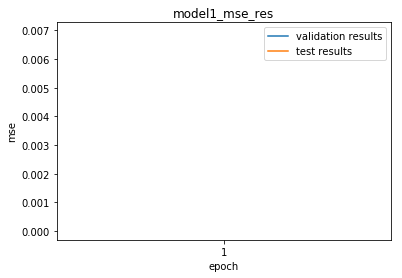

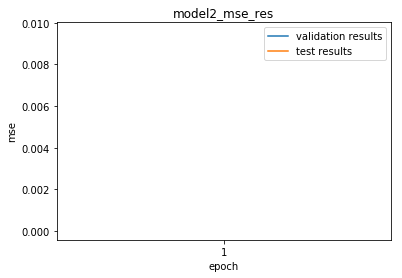

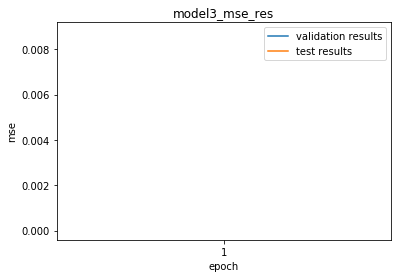

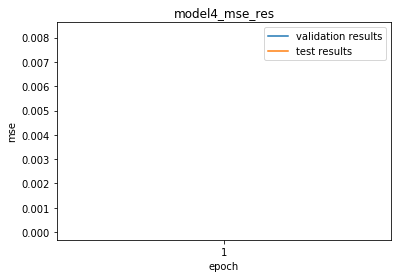

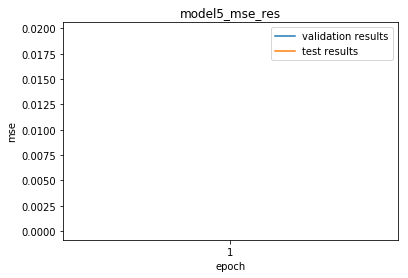

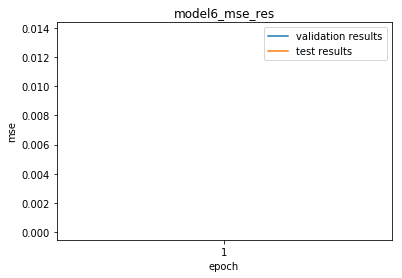

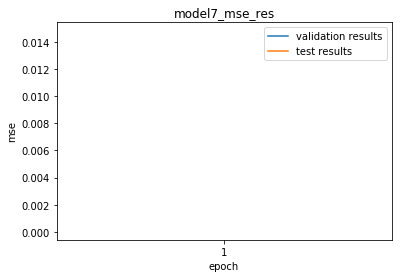

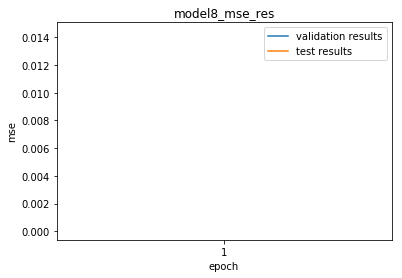

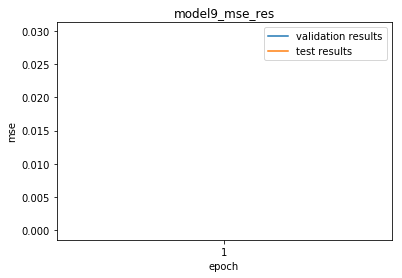

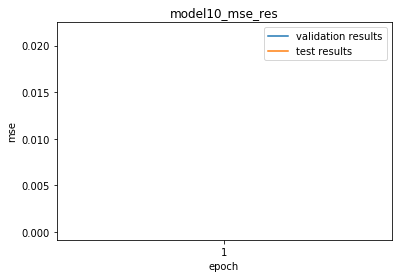

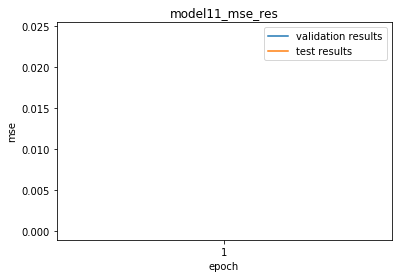

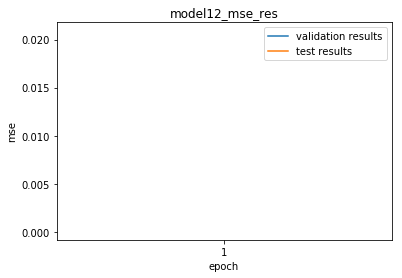

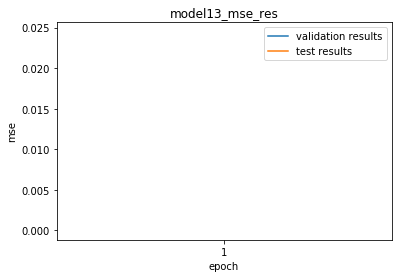

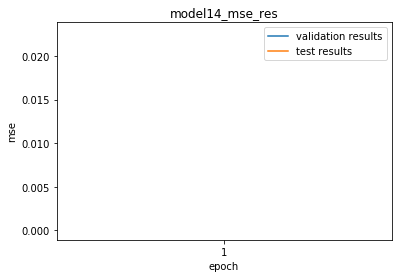

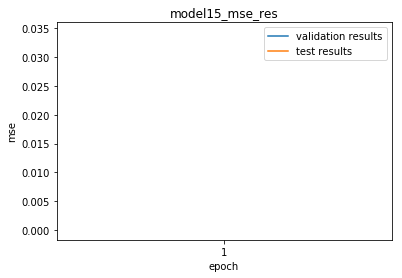

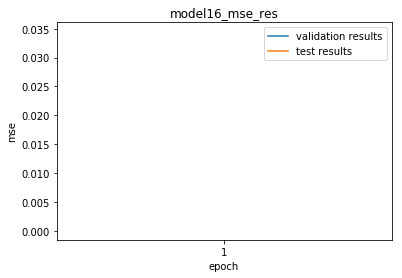

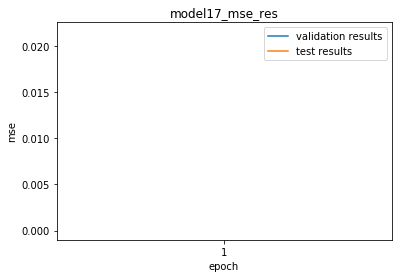

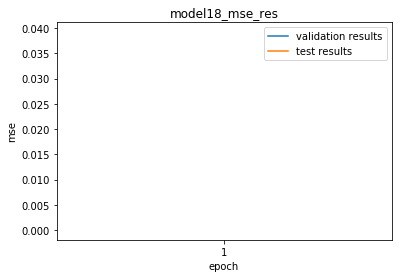

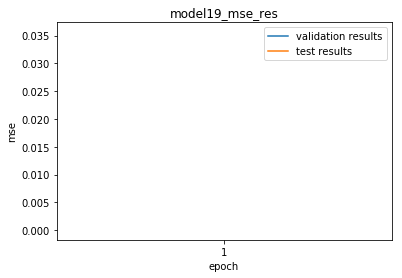

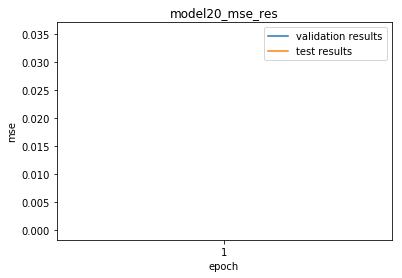

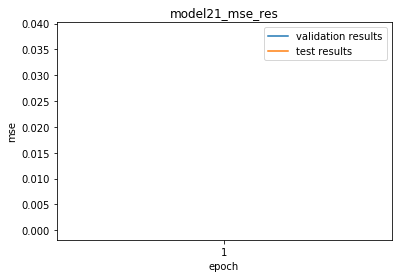

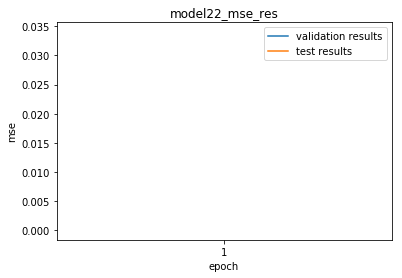

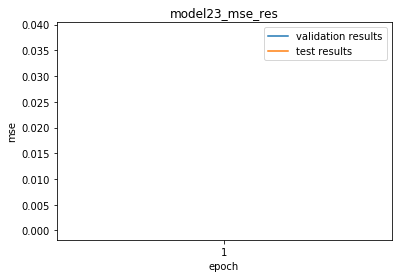

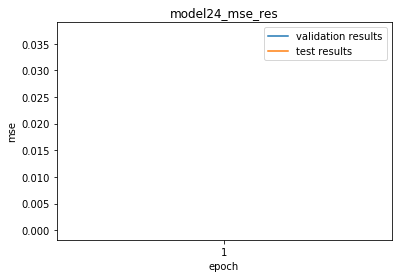

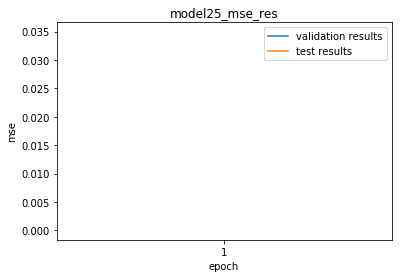

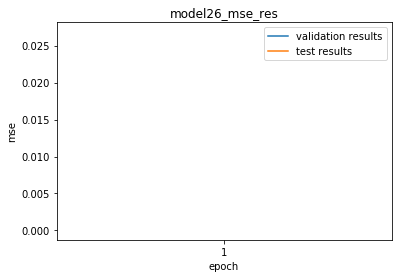

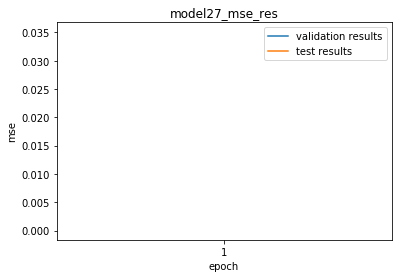

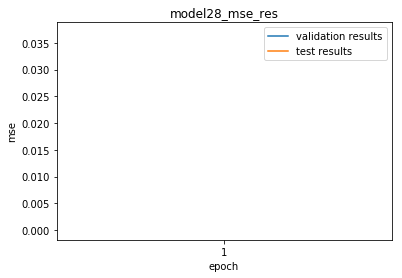

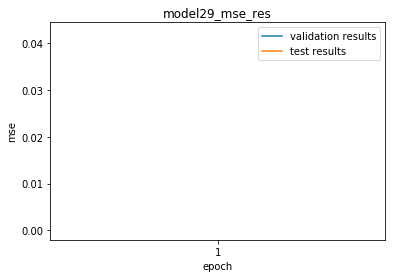

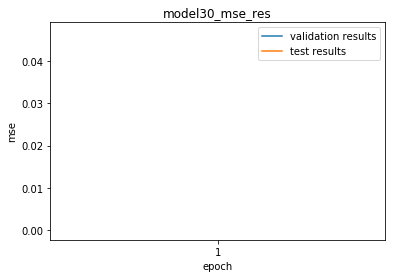

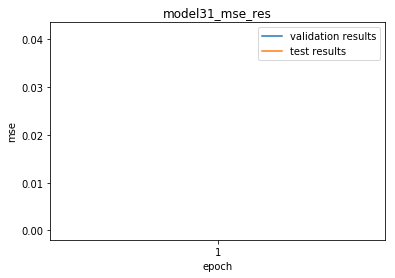

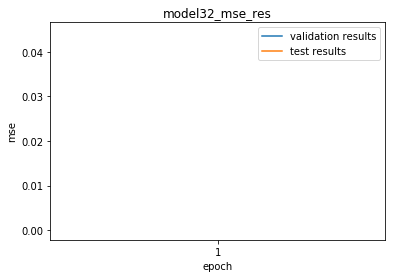

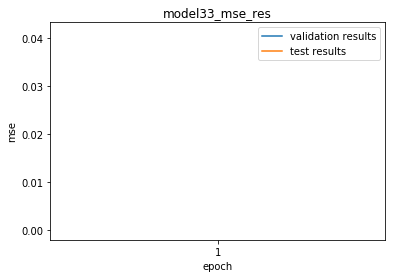

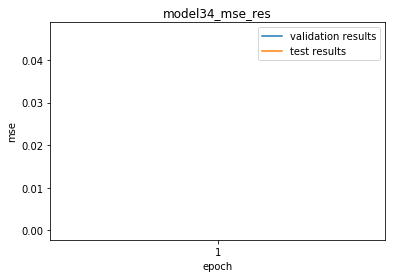

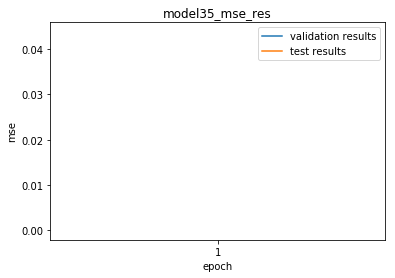

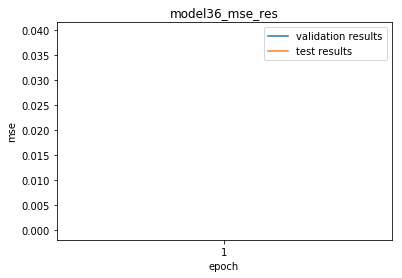

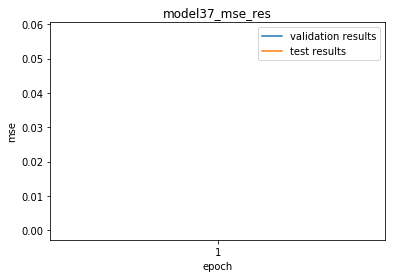

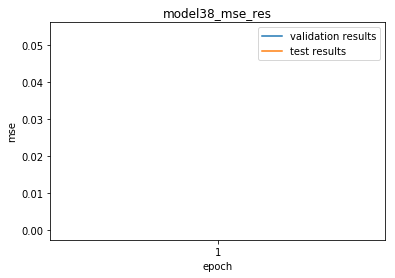

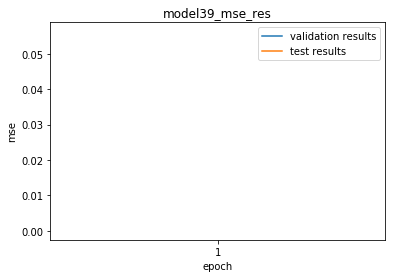

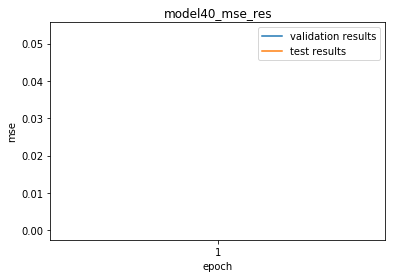

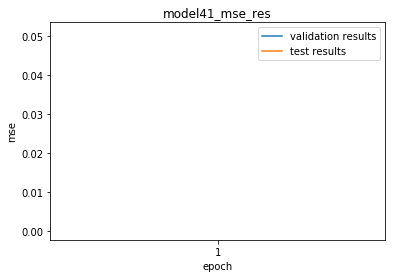

KeyboardInterrupt: ignored

In [6]:
# FIND BEST MODEL

import os, json
from matplotlib import pyplot as plt

#plot two metrics and save in result folder
def plot_and_save(metric_val, metric_test, x_labels, title, metric_name, time_step_name, res_dir):
    plt.plot(x_labels, metric_val, label="validation results")
    plt.plot(x_labels, metric_test, label="test results")
    plt.title(title)
    plt.ylabel(metric_name)
    plt.xlabel(time_step_name)
    plt.legend()
    plt.show()
    plt.savefig(os.path.join(res_dir, title+'.png'))
    plt.close()
  
results_dir = '/content/drive/My Drive/results'

def sorter(x):
  return float(x[0])

with open('/content/drive/My Drive/latex_out3.txt', 'a') as f:

  for i in range(1, 50):
      model_name = 'model'+str(i)
      result_dir = os.path.join(results_dir, model_name)
      with open(os.path.join(result_dir, model_name+'_results.json'), 'r') as fp:
          results = json.load(fp)

      mse_test = results['mse_test']
      mse_val = results['mse_validation']

      sort_test = sorted(mse_test.items(), key=sorter) # sorted by key, return a list of tuples
      sort_val = sorted(mse_val.items(), key=sorter)
      xt, yt = zip(*sort_test) # unpack a list of pairs into two tuples
      xv, yv = zip(*sort_val)


      plot_and_save(yv, yt, xt, model_name+'_mse_res', 'mse', 'epoch', results_dir)

      latx_name = model_name+'_mse_res.png'
      
      f.write('\\begin{figure}[H]\n\\centering\n\\includegraphics[width=0.4\\textwidth]{../images/'+latx_name+'}\n\\caption{'+model_name+')}\n\\label{'+model_name+'}\n\\end{figure}')
      f.write()

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive
